# Python @ Esri

# Topics

- Administering your GIS
- Working with Users
- Advanced Workflows

# Connecting to your GIS

First we need to grab the `GIS` module.

In [133]:
from arcgis.gis import GIS

## Where is your GIS?

ArcGIS Online is the default GIS.

In [134]:
from arcgis.gis import GIS

# ArcGIS Online is the default
GIS()

GIS @ https://www.arcgis.com version:7.1

If you need to be more specific, use the `url` argument.

Here we'll connect to a specific **ArcGIS Online Organization**.

In [135]:
# connect to an organization
GIS(url='https://dbsne.maps.arcgis.com')

GIS @ https://dbsne.maps.arcgis.com version:7.1

And this time, to an **ArcGIS Enterprise**.

In [136]:
# conect to ArcGIS Enterprise
GIS(url='https://esri.northeurope.cloudapp.azure.com/portal')

GIS @ https://esri.northeurope.cloudapp.azure.com/portal version:7.1

## Authentication

If no authentication scheme is used, your connection will be **anonymous**.

In [137]:
# connect anonymously
gis = GIS()

print(gis.users.me )

None


The most basic way to authenticate is with a username and password.

<User username:tech_trekkie>
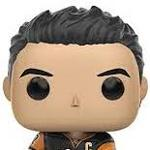

In [138]:
# username and password
gis = GIS(
  username='tech_trekkie',
  password='SidTheKid87'
)

gis.users.me

My favorite way to authenticate is with **Profiles** to store credentials using my operating system.

<User username:tech_trekkie>
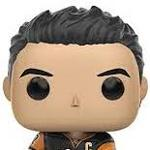

In [139]:
# save a profile ⭐
gis = GIS(
  username='tech_trekkie',
  password='SidTheKid87',
  profile='tech_trek_profile'
)

gis.users.me

Now you can use those stored credentials! (uses [keyring](https://pypi.org/project/keyring/)).

<User username:tech_trekkie>
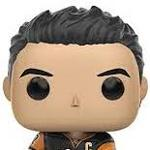

In [140]:
new_gis_who_dis = GIS(profile='tech_trek_profile')

new_gis_who_dis.users.me

Another super easy way to connect is by using ArcGIS Pro's stored credentials.

⚠️This requires ArcPy!

In [ ]:
# Use active Portal in ArcGIS Pro
gis = GIS('pro')

gis

# Working with Users

Let's set up our GIS connection.

In [172]:
gis = GIS(profile='portal')
gis

GIS @ https://esri.northeurope.cloudapp.azure.com/portal version:7.1

## Who are our Users?

Let's see a breakdown of the users in our GIS by fetching user counts by type.

❗The result is going to be a `pandas` DataFrame.

In [142]:
# get users by user type
df = gis.users.counts(type='user_type')
df

,count,key
0,4,basicUT
1,123,creatorUT
2,6,editorUT
3,15,fieldWorkerUT
4,13,GISProfessionalAdvUT


We can leverage `pandas` to quickly get a total count of users.

In [143]:
# using pandas dataframe
df['count'].sum()

161

## Creating a User

Let's first see what is needed to create a user.

In [150]:
# Open the help for the `arcgis.gis.users.create()` method
gis.users.create?

The first thing we need to know more about is the password policy. [Read the docs](https://developers.arcgis.com/rest/users-groups-and-items/update-security-policy.htm).

In [151]:
gis.admin.password_policy.policy

{
  "passwordPolicy": {
    "type": "custom",
    "minLength": 8,
    "minUpper": 1,
    "minLetter": 1,
    "minDigit": 1,
    "historySize": 5,
    "created": 1559005666510,
    "modified": 1559005750783
  }
}

Next, we need to understand the **roles** in this GIS. It's important to get this value dynamically from the GIS, as these ID's could change in future releases.

In [152]:
roles = gis.users.roles.all()
roles

[<Role name: Viewer, description: Viewer>,
 <Role name: Data Editor, description: Data Editor>,
 <Role name: GIS4SW Attendee, description: role for GIS4SW attendees>]

Let's create a **Data Editor**. We'll need the `role_id` in order to create this user.

In [154]:
role_id = roles[1].role_id
role_id

'iBBBBBBBBBBBBBBB'

Now we have what we need from the GIS – let's create a new user.

In [155]:
user = gis.users.create(username="obi_wan_esri",
                password='Us3Th3F0rc3',
                firstname="Ben",
                lastname="Kenobi",
                email="bkenobi@esri.com",
                role=role_id, # ⚠️ Avoid hardcoding this.
                user_type="creatorUT")
user

<User username:obi_wan_esri>

And to prove this user exists in the GIS, let's search for them...

In [156]:
user = gis.users.get('obi_wan_esri')
user

<User username:obi_wan_esri>

## Editing a User

Editing the properties of a user is super simple with `update`.

In [157]:
user.update(first_name='Obi Wan', thumbnail='./data/obi_wan.png')

True

And to verify our changes...

<User username:obi_wan_esri>
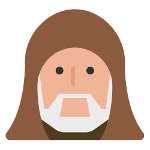

In [158]:
user

## Working with a User's Items

First, let's double check that this user doesn't have any items yet.

In [159]:
user.items()

[]

Let's add a dataset and publish it as a Feature Layer on behalf of the user.

In [ ]:
user

In [160]:
gis.users.me.role

'org_admin'

In [162]:
fp = "./data/crimes6.zip"
item_properties = {
    'title' : "Crimes 6",
    'type' : 'Shapefile',
    'tags' : ['Crimes']
}
shp_item = gis.content.add(data=fp, item_properties=item_properties, owner=user)
crimes_item = shp_item.publish()
crimes_item

KeyboardInterrupt: 

In [163]:
user.items()

[<Item title:"Crimes 5" type:Shapefile owner:obi_wan_esri>,
 <Item title:"Crimes 6" type:Shapefile owner:obi_wan_esri>,
 <Item title:"Crimes 6" type:Feature Layer Collection owner:obi_wan_esri>]

## Managing Credits

Credits only apply to ArcGIS Online Organizations

In [170]:
gis = GIS(profile='joshdbs')
user = gis.users.get('tech_trekkie')
user.assignedCredits

-1.0

Total number of credits in the Organization

In [165]:
# note that credit allocation can be disabled!
#gis.admin.credits.enable()

gis.admin.credits.credits

26180.088

Default credit limit

In [166]:
gis.admin.credits.default_limit

25

Available credits (for a user)

In [167]:
user.assignedCredits

1000.0

Allocate Credits

In [ ]:
gis.admin.credits.allocate(username=user.username, credits=1000)
user.availableCredits

In [ ]:
user.availableCredits

In [169]:
user.availableCredits

1000.0

Deallocate Credits

In [168]:
gis.admin.credits.deallocate(username=user.username)
user.assignedCredits

1000.0

## Deleting a User

We can delete our user with a single method. Note that users cannot be deleted if they own content – the `reassign_to` argument makes it easy to reassign content before deleting.

In [173]:
user = gis.users.get('obi_wan_esri')
user.items()

[<Item title:"Crimes 5" type:Shapefile owner:obi_wan_esri>,
 <Item title:"Crimes 6" type:Shapefile owner:obi_wan_esri>,
 <Item title:"Crimes 6" type:Feature Layer Collection owner:obi_wan_esri>]

In [174]:
user.delete()

Unable to delete user. User must not own items or groups.


RuntimeError: Unable to delete user. User must not own items or groups.
(Error Code: 400)

In [175]:
# Delete user, reassigning content to myself

user.delete(reassign_to=gis.users.me.username)

True

# Cloning Content

We need two GIS connections this time.

In [176]:
# connect to "source" GIS
gis_source = GIS(
  profile='joshdbs',
  set_active=False
)

# connect to "destination" GIS
gis = GIS(profile='portal')

Find the item we want to clone.

In [177]:
items_to_clone = gis_source.content.search(
    query='owner: joshdbs AND title: crimes',
    item_type='Feature Layer'
)
item

[<Item title:"Lubbock_Crimes_Fictional_Data" type:Feature Layer Collection owner:joshdbs>,
 <Item title:"Crimes 3" type:Feature Layer Collection owner:joshdbs>]

Finally, we will use `clone_items`.

In [178]:
# clone items
gis.content.clone_items(items=items_to_clone)

[<Item title:"Crimes 3" type:Feature Layer Collection owner:jpeterson>]

Let's search our destination GIS to see the cloned item.

In [179]:
items = gis.content.search(
    query='title: crimes',
    item_type='Feature Layer'
)
items

[<Item title:"Crimes" type:Feature Layer Collection owner:swuser.1>,
 <Item title:"Crimes 4" type:Feature Layer Collection owner:jpeterson>,
 <Item title:"Crimes 6" type:Feature Layer Collection owner:jpeterson>,
 <Item title:"Crimes 3" type:Feature Layer Collection owner:jpeterson>,
 <Item title:"Crimes 5" type:Feature Layer Collection owner:jpeterson>,
 <Item title:"Lubbock_Crimes_Fictional_Data" type:Feature Layer Collection owner:jpeterson>]

# Understand your GIS

Let's connect to our GIS.

In [180]:
gis = GIS(profile='joshdbs')
gis

GIS @ https://DBSNE.maps.arcgis.com version:7.1

## GIS History

As the admin of a GIS, we have access to the history of our GIS.

Let's use `matplotlib` and `pandas` to visualize a few things.

In [183]:
# notebook magic
%matplotlib inline

# dependencies
import datetime
import pandas as pd

# set up a time interval
then = datetime.datetime.now() - datetime.timedelta(days=10)

# get the history for our GIS as CSV, then read that with pandas
df = pd.read_csv(gis.admin.history(start_date=then, num=100000))

# preview our dataset
df.head()

,id,idType,orgId,owner,actor,ip,action,created,created_utc,request,reqId,clientId,data
0,camrine_DBSNE,u,BteRGjYsGtVEXzaX,NaN,camrine_DBSNE,18.210.1.103,failedlogin,1558369363015,"May 20, 2019 4:22:43 PM",/sharing/rest/generateToken,2e927422586e4a0a85dbae1468479971,ref.http://www.arcgis.com,NaN
1,camrine_DBSNE,u,BteRGjYsGtVEXzaX,NaN,camrine_DBSNE,18.210.1.103,failedlogin,1558373024723,"May 20, 2019 5:23:44 PM",/sharing/rest/generateToken,637fbd75a5ac4fa6a7dd4f2846c3c6b1,ref.http://www.arcgis.com,NaN
2,camrine_DBSNE,u,BteRGjYsGtVEXzaX,NaN,camrine_DBSNE,198.102.34.250,login,1558373050264,"May 20, 2019 5:24:10 PM",/sharing/generateToken,7708e2278db04a2c99ede79d506c7a75,ref.https://CAMRINE.esri.com:6143/geoevent/adm...,NaN
3,nick9534@esri.com_DBSNE,u,BteRGjYsGtVEXzaX,NaN,nick9534@esri.com_DBSNE,198.102.32.250,login,1558375095538,"May 20, 2019 5:58:15 PM",/sharing/rest/oauth2/token,3a3c0cc2f7104263b69321bbafb1b35a,arcgisprodesktop,NaN
4,nick9534@esri.com_DBSNE,u,BteRGjYsGtVEXzaX,NaN,nick9534@esri.com_DBSNE,198.102.32.250,login,1558375096442,"May 20, 2019 5:58:16 PM",/sharing/rest/oauth2/token,10ad78694ca6405e9bf3a7a51ffee314,arcgisprodesktop,NaN


Let's see what our data looks like as a chart.

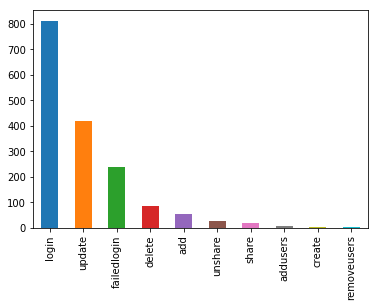

In [184]:
df.action.value_counts().plot.bar()

## Enterprise Logs

Next, let's check out the logs from an instance of ArcGIS Enterprise.

In [185]:
gis = GIS(profile='portal')
logs = gis.admin.logs
logs

<Logs at https://esri.northeurope.cloudapp.azure.com/portal/portaladmin/logs>

What are our current log settings?

In [187]:
logs.settings

{'logDir': 'C:\\portalforarcgis\\content\\arcgisportal\\logs\\',
 'logLevel': 'WARNING',
 'maxErrorReportsCount': 10,
 'maxLogFileAge': 90,
 'usageMeteringEnabled': False}

We can query the logs.

In [188]:
logs.query?

In [189]:
# dependencies
import datetime
import pandas as pd

# query logs from the last 10 days
results = logs.query(start_time=datetime.datetime.now() - datetime.timedelta(days=10))

# put the logs into a pandas dataframe
df = pd.DataFrame(results['logMessages'])

df.head()

,code,elapsed,machine,message,methodName,process,requestID,source,thread,time,type,user
0,217060,,GISFORSW-BASE.ZYZXGWFJWVIUXHXD4VJXTZE5OG.FX.IN...,The database server was found to be stopped. R...,,3880,,Portal,1,1559208096479,WARNING,
1,217060,,GISFORSW-BASE.ZYZXGWFJWVIUXHXD4VJXTZE5OG.FX.IN...,The database server was found to be stopped. R...,,3880,,Portal,1,1559202027546,WARNING,
2,217060,,GISFORSW-BASE.ZYZXGWFJWVIUXHXD4VJXTZE5OG.FX.IN...,The database server was found to be stopped. R...,,3880,,Portal,1,1559195035098,WARNING,
3,219999,,GISFORSW-BASE.ZYZXGWFJWVIUXHXD4VJXTZE5OG.FX.IN...,Failed to delete user 'obi_wan_esri'. Unable ...,,10808,,Sharing,1,1559158872545,WARNING,jpeterson
4,219999,,GISFORSW-BASE.ZYZXGWFJWVIUXHXD4VJXTZE5OG.FX.IN...,Failed to delete user 'obi_wan_esri'. User ca...,,10808,,Sharing,1,1559158872545,WARNING,jpeterson


And finally we can generate a simple chart of the severity (`type`) of our log records.

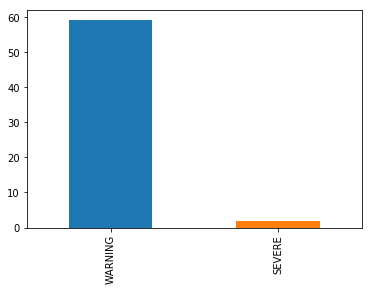

In [190]:
# notebook magic
%matplotlib inline

# plot the dataframe
df.type.value_counts().plot.bar()